In [1]:
# Authors:
# Freese, Julius <jufr23ac@student.cbs.dk>
# Haunberger, Vincent <viha23al@student.cbs.dk>
# Schröder, Fynn <fysc23ab@student.cbs.dk>

In [2]:
"""This notebook contains code for building a collaborative filtering recommendation
system. Parts of the code are implemented in the `cf_recommender.py` file. The model is
evaluated using common evaluation metrics on our common test set.
"""

'This notebook contains code for building a collaborative filtering recommendation\nsystem. Parts of the code are implemented in the `cf_recommender.py` file. The model is\nevaluated using common evaluation metrics on our common test set.\n'

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from common.data_loaders import (
    load_test_resp_eval_frame,
)
from common.cf_recommender import (
    create_user_item_matrix,
    matrix_factorization,
    compute_mse,
    recommend_items
)
from common.model_evaluation import (
    calculate_global_metrics,
    evaluate_recommendation
)

In [4]:
interactions = pd.read_csv('data/processed/interactions.csv').drop('Unnamed: 0', axis=1, errors='ignore')
users = pd.read_csv('data/processed/users.csv').drop('Unnamed: 0', axis=1, errors='ignore')
items = pd.read_csv('data/processed/items.csv').drop('Unnamed: 0', axis=1, errors='ignore')

In [5]:
eid_lookup = interactions.copy()
eid_lookup = eid_lookup[['eid', 'uid', 'cid', 'engagement_time', 'click']]
print(eid_lookup.shape)
eid_lookup.head(3)

(753299, 5)


,eid,uid,cid,engagement_time,click
0,5_6321_2024-01-30,5,6321,0.762305,1
1,5_6321_2024-02-05,5,6321,0.559014,1
2,8_585_2024-03-08,8,585,0.755245,1


In [6]:
# Set Subset of eid_lookup for local testing

n_train = 5_100
print("Final training set size: ", n_train)

eid_lookup_train = eid_lookup.sample(n=n_train, random_state=42)

# Shuffle the data
eid_lookup_train = eid_lookup_train.sample(frac=1)

Final training set size:  5100


In [7]:
# Get full list of users and items to ensure structure consistency
unique_users = eid_lookup_train['uid'].unique()
unique_items = eid_lookup_train['cid'].unique()

ui_matrix_train = create_user_item_matrix(eid_lookup_train, unique_users, unique_items)
print(ui_matrix_train.shape)

(4954, 1095)


### Matrix Factorization

Step 0: Training loss = 0.5647879543443799
Step 50: Training loss = 0.2554867096290182
Step 100: Training loss = 0.18514520465934745
Step 150: Training loss = 0.14631599929367048
Step 200: Training loss = 0.12054423613266477
Step 250: Training loss = 0.10198921601047037
Step 300: Training loss = 0.08798200007994834
Step 350: Training loss = 0.07706140533335408
Step 400: Training loss = 0.06833955808917298
Step 450: Training loss = 0.061239692231226
Step 499: Training loss = 0.05547639397028438


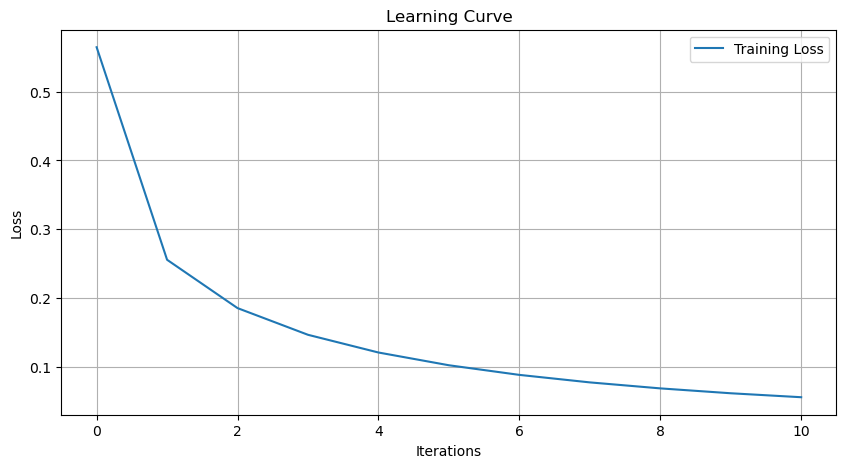

In [8]:
# Initialize variables
U_n = len(ui_matrix_train)
I_n = len(ui_matrix_train[0])
d = 5

U = np.random.rand(U_n, d)
V = np.random.rand(I_n, d)

# Run matrix factorization
nU, nV, train_losses = matrix_factorization(ui_matrix_train, U, V, d, steps=500, log_steps=50)

# Plotting the learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# took 2min 45 seconds

In [9]:
# estimated R matrix
nR = np.dot(nU, nV.T)
nR.shape

(4954, 1095)

In [10]:
random_matrix = np.random.uniform(0, 1, (U_n, I_n))

In [11]:
# Compute MSE for the random matrix on the test set
mse_random_matrix = compute_mse(ui_matrix_train, random_matrix)

# Assuming nP is the reconstructed matrix from your matrix factorization
mse_reconstructed_matrix = compute_mse(ui_matrix_train, nR)

print("Comparison of MSE:")
print(f" - Random Matrix:        {mse_random_matrix:.2f}")
print(f" - Matrix Factorization: {mse_reconstructed_matrix:.2f}")

Comparison of MSE:
 - Random Matrix:        0.12
 - Matrix Factorization: 0.06


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_items(user_id, user_ids, user_matrix, item_matrix, metric='cosine', top_n=10):
    """
    Generate item recommendations for a given user based on a similarity metric.

    Args:
    - user_id (int/str): Actual user ID as per your dataset
    - user_ids (np.array): Array of user IDs corresponding to the indices in the user_matrix
    - user_matrix (np.array): Matrix of user feature vectors (nP from matrix factorization)
    - item_matrix (np.array): Matrix of item feature vectors (nQ from matrix factorization)
    - metric (str): Similarity metric ('cosine' or 'dot'). Default is 'cosine'.

    Returns:
    - recommendations (np.array): Sorted array of item indices based on similarity scores
    """
    # Find the matrix index for the given user_id
    try:
        user_index = np.where(user_ids == user_id)[0][0]
    except IndexError:
        # user not found in the user_ids array; use random recommendation
        item_indices = np.random.choice(len(item_matrix), top_n, replace=False)
        item_scores = np.zeros(top_n)
        return item_indices, item_scores

    # Fetch the user feature vector
    user_vector = user_matrix[user_index, :]

    # Compute similarity scores
    if metric == 'cosine':
        scores = cosine_similarity(user_vector.reshape(1, -1), item_matrix)[0]
    elif metric == 'dot':
        scores = np.dot(user_vector, item_matrix.T)
    else:
        raise ValueError("Unsupported similarity metric. Choose 'cosine' or 'dot'.")

    # Sort item indices based on scores in descending order
    recommended_item_indices = np.argsort(-scores)[:top_n]

    return recommended_item_indices, scores[recommended_item_indices]

In [35]:
recommended_items, scores = recommend_items(509577, unique_users, U, V, top_n=10) # 509577
recommended_items, scores

(array([950, 540, 341, 583, 889, 947, 641, 590, 343, 342]),
 array([0.99457558, 0.99245274, 0.99214704, 0.98948203, 0.98947367,
        0.98941555, 0.9879714 , 0.98633789, 0.98532588, 0.98450364]))

### Evaluation

In [36]:
test_frame = load_test_resp_eval_frame()
print(test_frame.shape)
test_frame.head(3)

loading responses data ...
(50000, 6)


,uid,cid,Date,eid,prev_resp,future_resp
0,10,4592,2024-03-23,10_4592_2024-03-23,[],"[4592, 2069]"
1,10,2069,2024-03-23,10_2069_2024-03-23,[4592],[2069]
2,19,6351,2024-03-06,19_6351_2024-03-06,[],[6351]


In [47]:
TOP_K = 200

# iterate over all rows
cf_recommendations = {}
for idx, row in test_frame.iterrows():
    recommended_items, scores = recommend_items(row.uid, unique_users, U, V, top_n=TOP_K)
    cf_recommendations[row.eid] = {
        'recommended_items': recommended_items,
        'scores': scores
    }

cf_recs = pd.DataFrame(cf_recommendations).T
cf_recs.columns = ["recommended_ids", "scores"]
cf_recs["eid"] = cf_recs.index.values
cf_recs["recommended_ids"] = cf_recs["recommended_ids"].apply(lambda x: x.tolist())
cf_recs["scores"] = cf_recs["scores"].apply(lambda x: x.tolist())

In [49]:
cf_evaluation = evaluate_recommendation(cf_recs, test_frame)

# Calculate global metrics for multiple k values
global_metrics_df = calculate_global_metrics(cf_evaluation)
print("Global metrics for CFRecommender:")
print(global_metrics_df)

# Calculate global metrics for multiple k values
global_metrics_df = calculate_global_metrics(cf_evaluation[cf_evaluation['prev_resp'].apply(len) > 0])
print("\nGlobal metrics for CFRecommender [filtered]:")
print(global_metrics_df)

Global metrics for CFRecommender:
     Precision@k  Recall@k       MRR       MAP  Hit Rate  Coverage
10      0.000668  0.002381  0.001689  0.000232   0.00668       1.0
20      0.000578  0.004120  0.001383  0.000270   0.00744       1.0
50      0.001031  0.018370  0.000819  0.000332   0.01206       1.0
100     0.000625  0.022290  0.000850  0.000384   0.01662       1.0
200     0.000363  0.025883  0.000905  0.000433   0.02532       1.0

Global metrics for CFRecommender [filtered]:
     Precision@k  Recall@k       MRR       MAP  Hit Rate  Coverage
10      0.004015  0.003256  0.009978  0.000154  0.040153       1.0
20      0.003442  0.005582  0.007602  0.000174  0.040836       1.0
50      0.006512  0.026405  0.003316  0.000219  0.057635       1.0
100     0.003734  0.030282  0.003160  0.000261  0.061868       1.0
200     0.001956  0.031733  0.003196  0.000299  0.071155       1.0
